# NONCOVToolbox: Step 3

## Plot the data from the dataset and do explorative data analysis

### Load necessary modules from the NONCOVToolbox src

In [1]:
# Get the NONCOVToolbox library and print header
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.cluster import KMeans
import pathlib as Path
import importlib

path_noncov = os.path.abspath(os.path.join('..', '..', 'src'))

if path_noncov not in sys.path:
    sys.path.append(path_noncov)

from noncov import NONCOVToolbox, NONCOVHeader

noncov = NONCOVToolbox()

#NONCOVHeader.print_header()

# OrcaAnalysis module for postprocessing of DFT calculations
from noncov import OrcaAnalysis

# Functions to store data in dataframes
from noncov import MachineLearning

# Show performance and features of various NMR functions in module
from noncov import NMRFunctions

# Disable printing
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore printing
def enablePrint():
    sys.stdout = sys.__stdout__

In [2]:
# Get work directory and scratch folder for the output data
current_dir = os.getcwd()
print(f'Current work directory is: {current_dir}')

scratch_dir = os.path.abspath(os.path.join('..', '..', 'scratch'))
print(f'Current scratch directory is: {scratch_dir}')
scratch_dir = OrcaAnalysis().convert_path(scratch_dir)

Current work directory is: /Users/ettorebartalucci/Desktop/NONCOV/examples/KLaL_Cation_Pi_SGP
Current scratch directory is: /Users/ettorebartalucci/Desktop/NONCOV/scratch
Normalized path using os.path: /Users/ettorebartalucci/Desktop/NONCOV/scratch


### Show dataset

In [4]:
datasets_dir = os.path.join(scratch_dir, 'GenerateMLDataset/data/KLaL2/')
print(f'Dataset directory is: {datasets_dir}')
datasets_dir = OrcaAnalysis().convert_path(datasets_dir)

dataset_name = 'klal_gua_sgp_nmr.csv'

nucprop = os.path.join(datasets_dir, dataset_name)
nucprop_df = pd.read_csv(nucprop)

Dataset directory is: /Users/ettorebartalucci/Desktop/NONCOV/scratch/GenerateMLDataset/data/KLaL2/
Normalized path using os.path: /Users/ettorebartalucci/Desktop/NONCOV/scratch/GenerateMLDataset/data/KLaL2/


In [5]:
# Individual nuclear properties
nucprop_df.head()

,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_xx,sigma_yy,sigma_zz,dia_sigma_xx,...,dia_sigma_zz,para_sigma_xx,para_sigma_yy,para_sigma_zz,sigma_11,sigma_22,sigma_33,s_tot_symmetry,span,skew
0,KLaL_cation_pi_RCCE_opt_neg1p5.xyz,Nucleus 3H :,1.85056,-3.65399,-14.42354,27.48,34.49,24.83,23.12,-84.19,...,15.18,110.38,-49.03,10.94,23.12,24.83,34.49,0,11.37,-0.70
1,KLaL_cation_pi_RCCE_opt_neg1p5.xyz,Nucleus 4H :,-1.00867,-3.16908,-13.28325,26.93,23.21,27.63,29.96,-63.17,...,99.67,88.27,19.12,-72.09,23.21,27.63,29.96,0,6.75,0.31
2,KLaL_cation_pi_RCCE_opt_neg1p5.xyz,Nucleus 7H :,2.41198,-2.20461,-16.88088,24.21,29.69,20.16,22.79,-51.87,...,94.15,76.55,-34.07,-71.21,20.16,22.79,29.69,0,9.53,-0.45
3,KLaL_cation_pi_RCCE_opt_neg1p5.xyz,Nucleus 9H :,3.34765,-1.94550,-17.38756,24.75,20.50,26.42,27.34,14.47,...,63.21,11.32,-51.80,-40.55,20.50,26.42,27.34,0,6.84,0.73
4,KLaL_cation_pi_RCCE_opt_neg1p5.xyz,Nucleus 11H :,2.39691,-3.29532,-16.81784,24.16,29.66,20.16,22.66,136.21,...,59.12,-112.72,-0.88,-34.69,20.16,22.66,29.66,0,9.50,-0.47


## Feature selection before ML

We now want to select the features that will be most important for our Machine Learning application.

For Supervised Learning, in our dataset we have 20 features, and maybe we dont need all of them but only some. We can do feature selection in few ways:

* Correlation Matrix Plot
* Univariate Testing
* Recursive Feature Elimination with Cross Validation

### Correlation Matrix plot

From *Medium* Website: A correlation matrix is simply a table which displays the correlation coefficients for different variables. The matrix depicts the correlation between all the possible pairs of values in a table. It is a powerful tool to summarize a large dataset and to identify and visualize patterns in the given data.

A correlation matrix consists of rows and columns that show the variables. Each cell in a table contains the correlation coefficient.

In [10]:
# Do not work directly on the real data
df = nucprop_df

# Remove S_tot symmetry since its always zero - this needs to be checked, seems fishy
df = df.drop(columns='s_tot_symmetry')

df

,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_xx,sigma_yy,sigma_zz,dia_sigma_xx,dia_sigma_yy,dia_sigma_zz,para_sigma_xx,para_sigma_yy,para_sigma_zz,sigma_11,sigma_22,sigma_33,span,skew
0,KLaL_cation_pi_RCCE_opt_neg1p5.xyz,Nucleus 3H :,1.85056,-3.65399,-14.42354,27.48,34.49,24.83,23.12,-84.19,79.15,15.18,110.38,-49.03,10.94,23.12,24.83,34.49,11.37,-0.70
1,KLaL_cation_pi_RCCE_opt_neg1p5.xyz,Nucleus 4H :,-1.00867,-3.16908,-13.28325,26.93,23.21,27.63,29.96,-63.17,8.98,99.67,88.27,19.12,-72.09,23.21,27.63,29.96,6.75,0.31
2,KLaL_cation_pi_RCCE_opt_neg1p5.xyz,Nucleus 7H :,2.41198,-2.20461,-16.88088,24.21,29.69,20.16,22.79,-51.87,59.10,94.15,76.55,-34.07,-71.21,20.16,22.79,29.69,9.53,-0.45
3,KLaL_cation_pi_RCCE_opt_neg1p5.xyz,Nucleus 9H :,3.34765,-1.94550,-17.38756,24.75,20.50,26.42,27.34,14.47,77.62,63.21,11.32,-51.80,-40.55,20.50,26.42,27.34,6.84,0.73
4,KLaL_cation_pi_RCCE_opt_neg1p5.xyz,Nucleus 11H :,2.39691,-3.29532,-16.81784,24.16,29.66,20.16,22.66,136.21,25.44,59.12,-112.72,-0.88,-34.69,20.16,22.66,29.66,9.50,-0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3467,KLaL_cation_pi_RCCE_opt_4p0.xyz,Nucleus 51C :,-0.64706,4.78323,-14.92389,28.37,-58.28,104.06,39.33,155.14,300.32,275.68,-83.31,-226.82,-335.90,-58.28,39.33,104.06,162.34,0.20
3468,KLaL_cation_pi_RCCE_opt_4p0.xyz,Nucleus 57C :,-0.16135,2.99658,-15.68304,26.93,124.43,-25.19,-18.44,228.50,266.10,299.89,-111.28,-281.37,-321.04,-25.19,-18.44,124.43,149.62,-0.91
3469,KLaL_cation_pi_RCCE_opt_4p0.xyz,Nucleus 52N :,-0.96080,5.43763,-13.83124,175.86,115.64,183.03,228.92,400.42,335.44,318.86,-240.69,-156.50,-129.94,115.64,183.03,228.92,113.28,0.19
3470,KLaL_cation_pi_RCCE_opt_4p0.xyz,Nucleus 54N :,-0.96210,6.44135,-13.79599,176.95,229.48,181.91,119.47,197.29,312.53,360.00,-15.57,-193.70,-129.68,119.47,181.91,229.48,110.01,0.14


In [ ]:
# reorder entries in the database as 01, 02,...19
# Function to rename molecules containing 'disp_struct_' based on the number at the end
import re
def rename_molecule(name):
    match = re.search(r'(.*KLaL_cation_pi_RCCE_opt_)(\d+)', name)  # Find 'disp_struct_' followed by a number
    match2 = re.search(r'(.*KLaL_cation_pi_RCCE_opt_neg)(\d+)', name)
    
    if match:
        prefix = match.group(1)  # The 'disp_struct_' part
        number = int(match.group(2))  # Extract the number
        # Format the number with leading zero if < 10
        return f'{number}A'  # Add a leading zero

    return name  # If no match, return original name
    
    if match2:
        prefix = match2.group(1)  # The 'disp_struct_' part
        number = int(match2.group(2))  # Extract the number
        return f'-{number}A'  # Add a leading zero

# Apply the renaming function to the 'Molecule' column
df.loc[:,'Molecule'] = df['Molecule'].apply(rename_molecule)

df

In [ ]:
import seaborn as sns

# Total correlation matrix
f, ax = plt.subplots(figsize=(10, 8))

df_numeric = df.select_dtypes(include=[np.number])

corr = df_numeric.corr()

plt.title('Total correlation matrix')

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)

We can see that the paramagnetic components do not corelate strongly with the diamagnetic or span and skew. However, this is only the total correlation matrix. What about the individual nuclei?

In [ ]:
# Define the nucleus types you are interested in - these should be the ones you have in the simulations
nucleus_types = ['H', 'C', 'N ']

fig, axes = plt.subplots(2, 2, figsize=(15, 15))  # 3x3 grid
axes = axes.flatten()

# Iterate through each desired nucleus type and plot correlation heatmap
for i, nucleus in enumerate(nucleus_types):

    # This filters rows where the 'Atom' column contains the nucleus type, e.g., 'H' for 'Nucleus xH :'
    df_filtered = df[df['Atom'].str.contains(nucleus)]
    
    # Check the filtered data size - the sum of the individual rows should equal the total database!
    print(f'Nucleus {nucleus}: {df_filtered.shape[0]} rows')
    
    # Drop any non-numeric columns for correlation calculation
    df_numeric = df_filtered.select_dtypes(include=[np.number])
    
    # Filter columns with more than one unique value
    df_numeric = df_numeric.loc[:, df_numeric.nunique() > 1]
    
    # Drop rows with missing values (or fill missing values)
    df_numeric = df_numeric.dropna()

    # Run correlation matrix
    corr = df_numeric.corr()

    # Plot correlation heatmap for each nucleus type in the subplot
    if not corr.empty:
        sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
            cmap='plasma',  # or virdis, plasma coolwarm ecc..
            vmin=-1.0, vmax=1.0, square=True, ax=axes[i])

        # Set title for the subplot
        axes[i].set_title(f'Correlation for {nucleus} Nuclei', fontsize=12)
    else:
        axes[i].set_title(f'Nucleus {nucleus}: No data', fontsize=12)

# Hide any unused subplots
for j in range(len(nucleus_types), 4):  # Only 5 subplots used, hide the rest
    fig.delaxes(axes[j])

# Adjust layout to avoid overlapping
plt.tight_layout()  # Leave space for the color bar on the right

# Show the entire figure with subplots and the color bar
plt.show()

Which one of these features is strongly correlated with sigma_iso? we can reduce the correlation matrix to the 10 features that correlate the strongest with sigma_iso

In [ ]:
# Smaller correlation matrix for the top K features that have the highest correlation with sigma_iso
k = 5 

nucleus_types = ['H', 'C', 'N ', 'O', 'F']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid
axes = axes.flatten()

for i, nucleus in enumerate(nucleus_types):

    df_filtered = df[df['Atom'].str.contains(nucleus)]
    
    df_numeric = df_filtered.select_dtypes(include=[np.number])
    
    df_numeric = df_numeric.loc[:, df_numeric.nunique() > 1]
    
    df_numeric = df_numeric.dropna()

    corr = df_numeric.corr()

    if 'sigma_iso' in corr.columns:
        cols = corr.nlargest(k, 'sigma_iso')['sigma_iso'].index
        cm = np.corrcoef(df_numeric[cols].values.T)

    if cm.size > 0:
        sns.heatmap(cm, mask=np.zeros_like(cm, dtype=bool),
                    cmap='plasma',  # or viridis, coolwarm, etc.
                    annot=True, cbar=True, square=True, fmt='.2f',
                    ax=axes[i], xticklabels=cols.values, yticklabels=cols.values)

        axes[i].set_title(f'Correlation for {nucleus} Nuclei', fontsize=12)

for j in range(len(nucleus_types), 9):  # Only 5 subplots used, hide the rest
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# this is the same as above but for the total correlation matrix
cols = corr.nlargest(k, 'sigma_iso')['sigma_iso'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, cmap='plasma', square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Data Exploration of the dataset
Source: https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

In [ ]:
# Check how the database looks like
df.describe()

In [ ]:
# Check if any feature has missing values
df.isnull().sum()

In [ ]:
# View dataset types
df.dtypes

In [ ]:
fig = sns.distplot(df['sigma_iso']).get_figure()
plt.xlabel('$\sigma_{iso}$ / ppm (unreferenced)')
fig.savefig('sigma_iso_dataset.pdf', pad_inches=0.0)

print("Skewness: %f" % df['sigma_iso'].skew())
print("Kurtosis: %f" % df['sigma_iso'].kurt())

In [ ]:
import matplotlib.ticker as ticker


features_start_at = list(df.columns).index("sigma_iso")
feature_names = df.columns[features_start_at:]

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(12, 10), dpi=300)
axs = axs.flatten()  # so we don't have to slice by row and column
for i, n in enumerate(feature_names):
    ax = axs[i]
    sns.distplot(nucprop_df[n], ax=ax, color=f"C{i}").get_figure()  # add some color
    ax.set_xlabel(n)
# hide empty subplots
for i in range(len(feature_names), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()
fig.savefig('all_param_database.pdf')


In [ ]:
#scatterplot
sns.set()
cols = ['sigma_iso', 'sigma_xx', 'sigma_yy', 'sigma_zz', 'para_sigma_xx', 'para_sigma_yy', 'para_sigma_zz']
sns.pairplot(df[cols], size = 2.5)
plt.show();

In [ ]:
#scatterplot
sns.set()
cols = ['x_coord', 'y_coord', 'z_coord', 'sigma_iso', 'sigma_xx', 'sigma_yy', 'sigma_zz']
sns.pairplot(df[cols], size = 2.5)
plt.show();

In [ ]:
# Univariate analysis
# The primary concern here is to establish a 
# threshold that defines an observation as an outlier.
# To do so, we'll standardize the data. In this context,
# data standardization means converting data values to have 
# mean of 0 and a standard deviation of 1

#standardizing data
from sklearn.preprocessing import StandardScaler

sigma_iso_scaled = StandardScaler().fit_transform(df['sigma_iso'][:,np.newaxis]);
low_range = sigma_iso_scaled[sigma_iso_scaled[:,0].argsort()][:10]
high_range= sigma_iso_scaled[sigma_iso_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)


In [ ]:
# Bivariate analysis
#bivariate analysis saleprice/grlivarea
var = 'para_sigma_xx'
data = pd.concat([df['sigma_iso'], df[var]], axis=1)
data.plot.scatter(x=var, y='sigma_iso');

In [ ]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

### Explorative Data Analysis
Source: https://dmol.pub/ml/introduction.html

In [ ]:
sns.displot(df.sigma_iso)

In [ ]:
# get 3 lowest and 3 highest sigma_iso
sigma_iso_sorted = df.sort_values("sigma_iso")
extremes = pd.concat([sigma_iso_sorted[:3], sigma_iso_sorted[-3:]])

# We need to have a list of strings for legends
legend_text = [
    f"{x.Molecule}: sigma_iso = {x.sigma_iso:.2f}" for x in extremes.itertuples()
]

extremes

In [ ]:
features_start_at = list(nucprop_df.columns).index("sigma_iso")
feature_names = nucprop_df.columns[features_start_at:]

fig, axs = plt.subplots(nrows=5, ncols=4, sharey=True, figsize=(12, 8), dpi=300)
axs = axs.flatten()  # so we don't have to slice by row and column
for i, n in enumerate(feature_names):
    ax = axs[i]
    ax.scatter(
        nucprop_df[n], nucprop_df.sigma_iso, s=6, alpha=0.4, color=f"C{i}"
    )  # add some color
    if i % 4 == 0:
        ax.set_ylabel("Isotropic Shielding")
    ax.set_xlabel(n)
# hide empty subplots
for i in range(len(feature_names), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()
fig.savefig('sigma_iso_correlations.pdf')

## Dependence of NMR parameters with respect to fragments displacement

Now we want to check how the NMR parameters change as a function of the displacement. As a recapitulation, we have the following data:

* Three NCI types, Hp-pi, Cation-pi, Anion-pi
* Each of these interactions is mediated by one type of anion, cation or H donor, and three aromatics, namely Phe, Tyr, Trp
* For tryptophan we also explore the effects of progressive fluorinations of the aromatic ring on the shifts of the interacting partner
* The 'dissociation limit' is set as 20 iteration each being 0.25 Angstroms more displaced

### Filtering and reordering the databases

Split the database into three separate ones, one for each interaction.
This helps in handling plots and allows to not work on the real df.

In [12]:
# reference values calculated at pbe0/pcsseg2
# values are an average since the molecules are symmetric

sigma_1h_tms = 31.44
sigma_13c_tms = 185.43
sigma_15n_nh3 = 263.54 #check on cluster

sigma_1h_gua_free = 26.51
sigma_13c_gua_free = 22.09
sigma_15n_gua_free = 172.36

print(sigma_13c_tms - sigma_13c_gua_free)

# chemical shifts: delta_sgp = sigma_tms - sigma_sgp
# delta_delta = delta_gua - delta_sgp

163.34


In [14]:
# now listing all the nuclei of interest for each pair. 
# keep in mind, orca nuclei start from 0, so if in avogadro is Nucleus C21, in the database is Nucleus C20

############################################################################################
sgp_13C = ['Nucleus 57C :']

sgp_15N1 = ['Nucleus 52N :']

sgp_15N2 = ['Nucleus 54N :']

sgp_15N3 = ['Nucleus 59N :']

sgp_1H1 = ['Nucleus 53H :']

sgp_1H2 = ['Nucleus 58H :']

sgp_1H3 = ['Nucleus 61H :']

sgp_1H4 = ['Nucleus 60H :']

sgp_1H5 = ['Nucleus 56H :']

sgp_1H6 = ['Nucleus 55H :']

In [16]:
# subset the DataFrame with a specific value in a column
subset_13C = df[df['Atom'].isin(sgp_13C)]

subset_15N1 = df[df['Atom'].isin(sgp_15N1)]
subset_15N2 = df[df['Atom'].isin(sgp_15N2)]
subset_15N3 = df[df['Atom'].isin(sgp_15N3)]

subset_1H1 = df[df['Atom'].isin(sgp_1H1)]
subset_1H2 = df[df['Atom'].isin(sgp_1H2)]
subset_1H3 = df[df['Atom'].isin(sgp_1H3)]
subset_1H4 = df[df['Atom'].isin(sgp_1H4)]
subset_1H5 = df[df['Atom'].isin(sgp_1H5)]
subset_1H6 = df[df['Atom'].isin(sgp_1H6)]

In [20]:
# referencing
xdat = np.arange(-1.5, 4.1, 0.1)

# chemical-shift
delta_13C = sigma_13c_tms - subset_13C['sigma_iso']
delta_15N1 = sigma_15n_nh3 - subset_15N1['sigma_iso']
delta_15N2 = sigma_15n_nh3 - subset_15N2['sigma_iso']
delta_15N3 = sigma_15n_nh3 - subset_15N3['sigma_iso']
delta_1H1 = sigma_1h_tms - subset_1H1['sigma_iso']
delta_1H2 = sigma_1h_tms - subset_1H2['sigma_iso']
delta_1H3 = sigma_1h_tms - subset_1H3['sigma_iso']
delta_1H4 = sigma_1h_tms - subset_1H4['sigma_iso']
delta_1H5 = sigma_1h_tms - subset_1H5['sigma_iso']
delta_1H6 = sigma_1h_tms - subset_1H6['sigma_iso']

# chemical shift with respect to dissociation
delta_delta_13C = -(sigma_13c_tms - sigma_13c_gua_free) + delta_13C
delta_delta_15N1 = -(sigma_15n_nh3 - sigma_15n_gua_free) + delta_15N1
delta_delta_15N2 = -(sigma_15n_nh3 - sigma_15n_gua_free) + delta_15N2
delta_delta_15N3 = -(sigma_15n_nh3 - sigma_15n_gua_free) + delta_15N3
delta_delta_1H1 = -(sigma_1h_tms - sigma_1h_gua_free) + delta_1H1
delta_delta_1H2 = -(sigma_1h_tms - sigma_1h_gua_free) + delta_1H2
delta_delta_1H3 = -(sigma_1h_tms - sigma_1h_gua_free) + delta_1H3
delta_delta_1H4 = -(sigma_1h_tms - sigma_1h_gua_free) + delta_1H4
delta_delta_1H5 = -(sigma_1h_tms - sigma_1h_gua_free) + delta_1H5
delta_delta_1H6 = -(sigma_1h_tms - sigma_1h_gua_free) + delta_1H6

## Plots of $\sigma$ vs. Displacement

<>:8: SyntaxWarning: invalid escape sequence '\A'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\A'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\A'
<>:27: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\A'
<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\A'
<>:47: SyntaxWarning: invalid escape sequence '\D'
<>:56: SyntaxWarning: invalid escape sequence '\A'
<>:57: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\A'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\A'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\A'
<>:27: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\A'
<>:37: SyntaxWarning: invalid escap

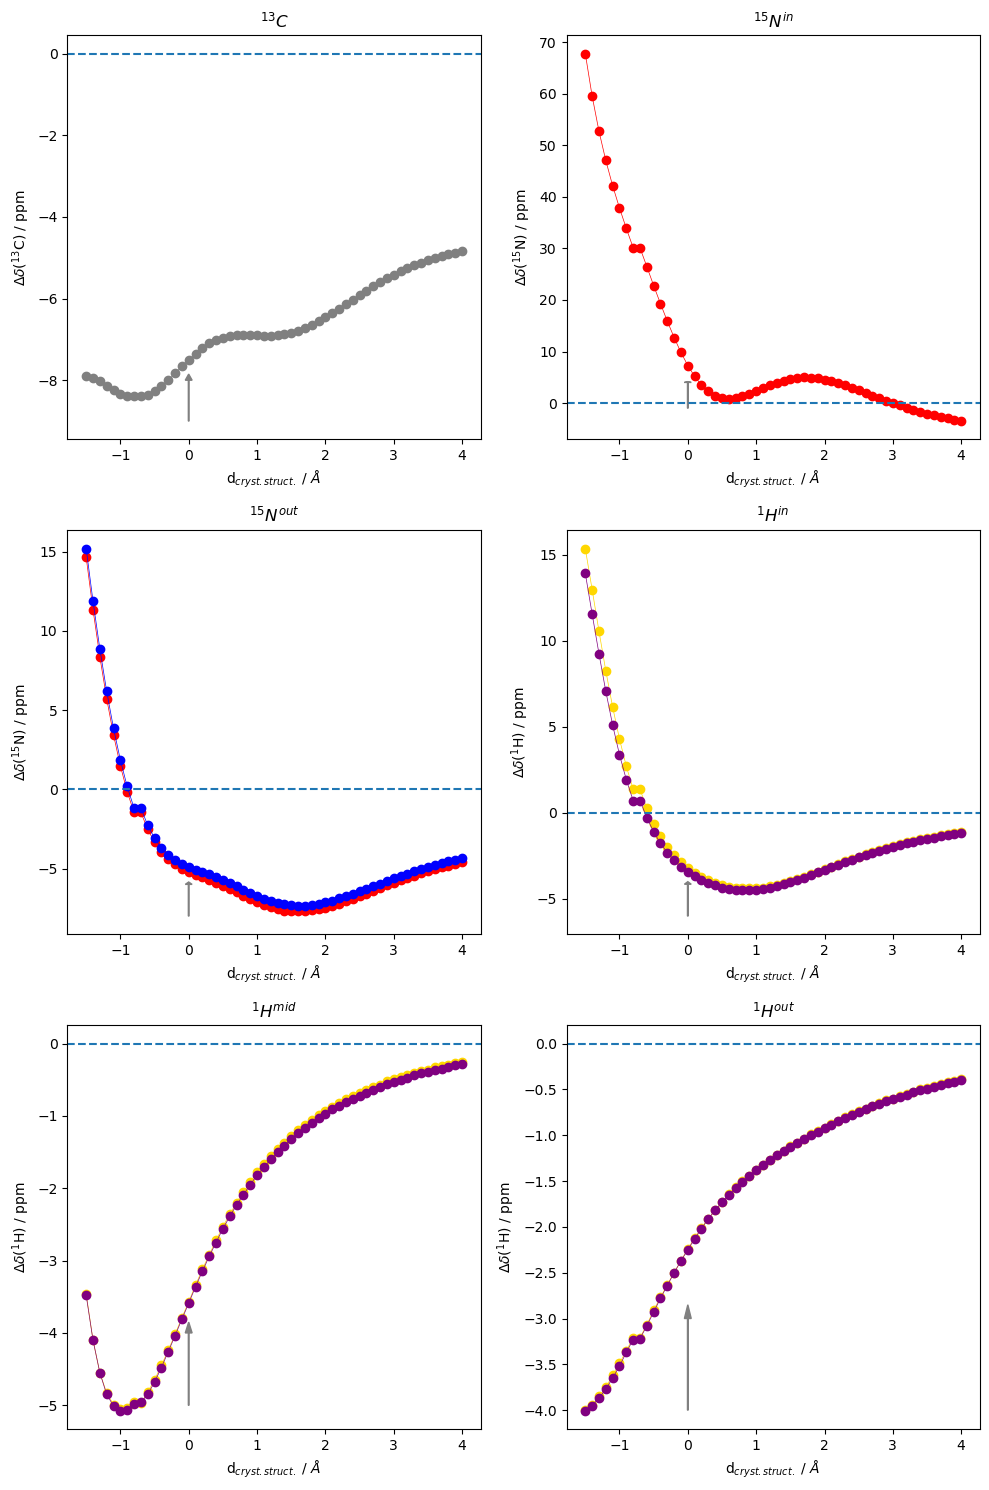

In [44]:
fig = plt.figure(figsize=(10, 15))

plt.subplot(3, 2, 1) 
plt.title("$^{13}C$")
plt.plot(xdat,delta_delta_13C, '-o', color='grey',linewidth=0.5)
plt.axhline(0, linestyle='--')
plt.arrow(0,-9,0,1,width=0.01,head_width=0.1, color='grey')
plt.xlabel('d$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{13}$C) / ppm')


plt.subplot(3, 2, 2) 
plt.title("$^{15}N^{in}$")
plt.plot(xdat,delta_delta_15N1, '-o', color='red',linewidth=0.5)
plt.axhline(0, linestyle='--')
plt.arrow(0,-1,0,5,width=0.01,head_width=0.1, color='grey')
plt.xlabel('d$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{15}$N) / ppm')

plt.subplot(3, 2, 3) 
plt.title("$^{15}N^{out}$")
plt.plot(xdat,delta_delta_15N2, '-o', color='red',linewidth=0.5)
plt.plot(xdat,delta_delta_15N3, '-o', color='blue',linewidth=0.5)
plt.axhline(0, linestyle='--')
plt.arrow(0,-8,0,2,width=0.01,head_width=0.1, color='grey')
plt.xlabel('d$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{15}$N) / ppm')


plt.subplot(3, 2, 4) 
plt.title("$^{1}H^{in}$")
plt.plot(xdat,delta_delta_1H1, '-o', color='gold',linewidth=0.5)
plt.plot(xdat,delta_delta_1H2, '-o', color='purple',linewidth=0.5)
plt.arrow(0,-6,0,2,width=0.01,length_includes_head=True, head_width=0.1, color='grey')
plt.axhline(0, linestyle='--')
plt.xlabel('d$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{1}$H) / ppm')


plt.subplot(3, 2, 5) 
plt.title("$^{1}H^{mid}$")
plt.plot(xdat,delta_delta_1H3, '-o', color='gold',linewidth=0.5)
plt.plot(xdat,delta_delta_1H5, '-o', color='purple',linewidth=0.5)
plt.axhline(0, linestyle='--')
plt.arrow(0,-5,0,1,width=0.01,head_width=0.1, color='grey')
plt.xlabel('d$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{1}$H) / ppm')


plt.subplot(3, 2, 6) 
plt.title("$^{1}H^{out}$")
plt.plot(xdat,delta_delta_1H4, '-o', color='gold',linewidth=0.5)
plt.plot(xdat,delta_delta_1H6, '-o', color='purple',linewidth=0.5)
plt.axhline(0, linestyle='--')
plt.arrow(0,-4,0,1,width=0.01,head_width=0.1, color='grey')
plt.xlabel('d$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{1}$H) / ppm')

plt.tight_layout()
plt.show()
fig.savefig('klal_sgp_Dd.pdf', pad_inches=0.0)

In [ ]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1) 
plt.title("$^{13}C$")
plt.plot(xdat,delta_13C, '-o', color='grey',linewidth=0.5)
plt.arrow(0,154,0,1,width=0.01,head_width=0.1, color='grey')
plt.xlabel('r$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{13}$C) / ppm')


plt.subplot(3, 2, 2) 
plt.title("$^{15}N^{in}$")
plt.plot(xdat,delta_15N1, '-o', color='red',linewidth=0.5)
plt.arrow(0,84,0,4,width=0.01,head_width=0.1, color='grey')
plt.xlabel('r$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{15}$N) / ppm')

plt.subplot(3, 2, 3) 
plt.title("$^{15}N^{out}$")
plt.plot(xdat,delta_15N2, '-o', color='red',linewidth=0.5)
plt.plot(xdat,delta_15N3, '-o', color='blue',linewidth=0.5)
plt.arrow(0,83,0,1,width=0.01,head_width=0.1, color='grey')
plt.xlabel('r$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{15}$N) / ppm')


plt.subplot(3, 2, 4) 
plt.title("$^{1}H^{in}$")
plt.plot(xdat,delta_1H1, '-o', color='gold',linewidth=0.5)
plt.plot(xdat,delta_1H2, '-o', color='purple',linewidth=0.5)
plt.arrow(0,-1,0,1,width=0.01,head_width=0.1, color='grey')
plt.xlabel('r$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{1}$H) / ppm')


plt.subplot(3, 2, 5) 
plt.title("$^{1}H^{mid}$")
plt.plot(xdat,delta_1H3, '-o', color='gold',linewidth=0.5)
plt.plot(xdat,delta_1H5, '-o', color='purple',linewidth=0.5)
plt.arrow(0,0,0,0.7,width=0.01,head_width=0.1, color='grey')
plt.xlabel('r$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{1}$H) / ppm')


plt.subplot(3, 2, 6) 
plt.title("$^{1}H^{out}$")
plt.plot(xdat,delta_1H4, '-o', color='gold',linewidth=0.5)
plt.plot(xdat,delta_1H6, '-o', color='purple',linewidth=0.5)
plt.arrow(0,1,0,1,width=0.01,head_width=0.1, color='grey')
plt.xlabel('r$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{1}$H) / ppm')

plt.tight_layout()
plt.show()
#fig.savefig('klal_sgp_Dd.pdf', pad_inches=0.0)

In [ ]:
# chemical-shielding
pxx_sigma_15N1 = subset_15N1['sigma_11']
pyy_sigma_15N1 = subset_15N1['sigma_22']
pzz_sigma_15N1 = subset_15N1['sigma_33']

pxx_sigma_15N2 = subset_15N2['sigma_xx']
pyy_sigma_15N2 = subset_15N2['sigma_yy']
pzz_sigma_15N2 = subset_15N2['sigma_zz']

pxx_sigma_15N3 = subset_15N3['sigma_xx']
pyy_sigma_15N3 = subset_15N3['sigma_yy']
pzz_sigma_15N3 = subset_15N3['sigma_zz']

fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1) 
plt.title("$^{13}C$")
plt.plot(xdat,pxx_sigma_15N1, '-o', color='red',linewidth=0.5)
plt.plot(xdat,pyy_sigma_15N1, '-o', color='blue',linewidth=0.5)
plt.plot(xdat,pzz_sigma_15N1, '-o', color='gold',linewidth=0.5)
plt.xlabel('r$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{13}$C) / ppm')


plt.subplot(3, 2, 2) 
plt.title("$^{15}N^{in}$")
plt.plot(xdat,pxx_sigma_15N2, '-o', color='red',linewidth=0.5)
plt.plot(xdat,pyy_sigma_15N2, '-o', color='blue',linewidth=0.5)
plt.plot(xdat,pzz_sigma_15N2, '-o', color='gold',linewidth=0.5)
plt.xlabel('r$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{15}$N) / ppm')

plt.subplot(3, 2, 3) 
plt.title("$^{15}N^{out}$")
plt.plot(xdat,pxx_sigma_15N3, '-o', color='red',linewidth=0.5)
plt.plot(xdat,pyy_sigma_15N3, '-o', color='blue',linewidth=0.5)
plt.plot(xdat,pzz_sigma_15N3, '-o', color='gold',linewidth=0.5)
plt.xlabel('r$_{cryst. struct.}$ / $\AA$')
plt.ylabel('$\Delta\delta$($^{15}$N) / ppm')

plt.tight_layout()
plt.show()
#fig.savefig('klal_sgp_Dd.pdf', pad_inches=0.0)